# Responses for Chandra/HETG

Let's see if we can figure out responses for the Chandra/HETG. This notebook will require `sherpa`, because we're using this for comparison purposes!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    print("No seaborn installed. Oh well.")
    
import numpy as np 
import pandas as pd
import astropy.io.fits as fits
import sherpa.astro.ui as ui

from clarsach.respond import RMF, ARF


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


Let's load some HETG simulations:

In [2]:
datadir = "/Users/danielahuppenkothen/work/repositories/shiftylines/data/cygx1_sims/"

ui.load_data(id="f0_heg_p1", filename=datadir+"fake_heg_p1_5ks_ident0_src.pha")


statistical errors were found in file '/Users/danielahuppenkothen/work/repositories/shiftylines/data/cygx1_sims/fake_heg_p1_5ks_ident0_src.pha' 
but not used; to use them, re-read with use_errors=True
read ARF file /Users/danielahuppenkothen/work/repositories/shiftylines/data/cygx1_sims/heg_p1.arf
detchans: 8192
self._lo.shape: 8192
e_min.shape: 8192
read RMF file /Users/danielahuppenkothen/work/repositories/shiftylines/data/cygx1_sims/heg_p1.rmf
len(bin_lo): 8192


In [11]:
lines = np.loadtxt(datadir+"../si_lines.txt")
c = 12.3984191
lines_kev = c/lines


min_e = 6.0499997575723086
max_e = 7.100000097785645

# same in keV, because that's what our spectrum is in!
min_kev = c/max_e
max_kev = c/min_e

Let's load the data into a variable we can actually use:

In [12]:
d_p1 = ui.get_data("f0_heg_p1")


In [16]:
# sorted indices
idx_heg = d_p1.bin_lo.argsort()

# the low bin edges
bin_lo_p1 = d_p1.bin_lo[idx_heg]
bin_hi_p1 = d_p1.bin_hi[idx_heg]

# let's get the counts
counts_p1 = d_p1.counts[idx_heg]

# this is the mid-bins
bin_mid_p1 = bin_lo_p1 + (bin_hi_p1 - bin_lo_p1)/2.0

# the indices of the part of the spectrum we care about
min_idx = bin_lo_p1.searchsorted(min_kev)
max_idx = bin_hi_p1.searchsorted(max_kev)

# the bin edges (and middle) and the counts in 
# the range we're interested in
bl_small = bin_lo_p1[min_idx:max_idx]
bh_small = bin_hi_p1[min_idx:max_idx]
bm_small = bin_mid_p1[min_idx:max_idx]
c_small_p1 = counts_p1[min_idx:max_idx]

# this is the length of the counts array:
len_small = len(c_small_p1)

Let's get out the ARF:

In [17]:
arf = d_p1.get_arf()
specresp = arf.specresp

specresp_small = specresp[min_idx:max_idx]


Let's also compute the deconvolved spectrum

In [18]:
c_arf = counts_p1/specresp
c_arf_small = c_arf[min_idx:max_idx]

# we can do the same with sherpa
ui.set_source("f0_heg_p1", ui.polynom1d.truespec)
c_deconv = ui.get_ratio_plot("f0_heg_p1").y
e_deconv = ui.get_ratio_plot("f0_heg_p1").x

c_deconv_small = c_deconv[min_idx:max_idx]
e_deconv_small = e_deconv[min_idx:max_idx]


size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192


I have some models that I calculated with another project that we can use as models without responses applied to them:

In [19]:
samples = np.loadtxt(datadir+"../tests/test3_posterior_sample.txt")
print("There are %i samples."%len(samples))

There are 80 samples.


Let's get the model spectra out of this:

In [20]:
len_small = len(c_small_p1)

full_model = samples[:, -len_small:]
model_with_ou = samples[:, -2*len_small:-len_small]
model_with_arf = samples[:, -3*len_small:-2*len_small]
model_with_bkg = samples[:, -4*len_small:-3*len_small]
model_with_lines = samples[:, -5*len_small:-4*len_small]
ou_process = samples[:, -6*len_small:-5*len_small]

Let's see if we can fold this through the RMF using `sherpa`:

In [21]:
m = model_with_bkg[0,:]

These are the ARF/RMF objects:

In [22]:
arf = d_p1.get_arf()
rmf = d_p1.get_rmf()

We need to make a padded array for the parts of the spectrum where I didn't calculate a model:

In [23]:
nchannels = len(bin_lo_p1)
padded_model = np.zeros(nchannels) 
padded_model[min_idx:max_idx] = m
padded_model[:min_idx] = samples[0,0]
padded_model[max_idx:] = samples[0,0]

In [24]:
m_arf = arf.apply_arf(padded_model)
m_arf2 = padded_model * arf.specresp
m_rmf = rmf.apply_rmf(m_arf)

size(src): 8192
folded model size: 8192


Let's plot what that looks like:

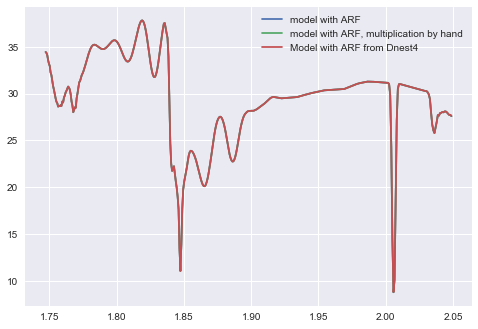

In [30]:
plt.figure()
#plt.plot(bm_small, m, label="Model with lines")
plt.plot(bm_small, m_arf[min_idx:max_idx], label="model with ARF")
plt.plot(bm_small, m_arf2[min_idx:max_idx], label="model with ARF, multiplication by hand")
plt.plot(bm_small, model_with_arf[0], label="Model with ARF from Dnest4")
plt.legend()

That seems to have done the right thing!

Let's check whether the model with ARF from DNest4, the model with ARF from Sherpa and the model that I multiplied by the spectral response by hand are the same:

In [31]:
np.allclose(m_arf[min_idx:max_idx], model_with_arf[0])

True

In [32]:
np.allclose(m_arf2[min_idx:max_idx], model_with_arf[0])

True

They are! That's exciting! Let's plot them compared to the data:

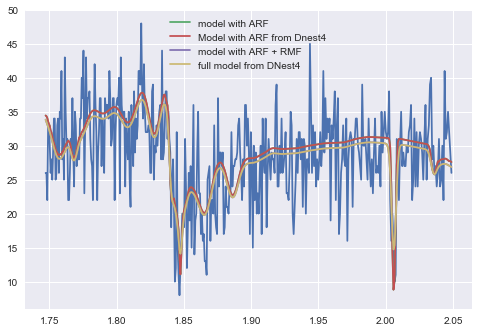

In [34]:
plt.figure()
plt.plot(bm_small, c_small_p1)
plt.plot(bm_small, m_arf[min_idx:max_idx], label="model with ARF")
plt.plot(bm_small, model_with_arf[0], label="Model with ARF from Dnest4")
plt.plot(bm_small, m_rmf[min_idx:max_idx], label="model with ARF + RMF")
plt.plot(bm_small, full_model[0, :], label="full model from DNest4")
plt.legend()

Let's now look at the RMF:

In [35]:
nchannels = len(bin_lo_p1)
padded_model = np.zeros(nchannels) + samples[0,0]
padded_model[min_idx:max_idx] = model_with_arf[0]
m_rmf2 = rmf.apply_rmf(padded_model)

size(src): 8192
folded model size: 8192


In [36]:
np.allclose(m_rmf[min_idx:max_idx], full_model[0])

True

Okay, so I have a basic understanding of how responses work in theory. We're now going to write our own implementations, and then test them on the model above.

Let's first write a function for applying the ARF. This is easy, because the ARF just requires a multiplication with the input spectrum.

In [37]:
def apply_arf(spec, specresp):
    """
    Apply the anxilliary response to 
    a spectrum. 
    
    Parameters
    ----------
    spec : numpy.ndarray
        The source spectrum in flux units
        
    specresp: numpy.ndarray
        The response 
        
    Returns
    -------
    spec_arf : numpy.ndarray
        The spectrum with the response applied.
    
    """
    spec_arf = spec*specresp
    return spec_arf

Let's try it!

In [38]:
m = model_with_bkg[0]

# need to pad the model
padded_model = np.zeros_like(bin_lo_p1)
padded_model[min_idx:max_idx] = m
padded_model[:min_idx] = samples[0,0]
padded_model[max_idx:] = samples[0,0]

In [39]:
m_arf = apply_arf(padded_model, arf.specresp)

We can compare that with the result from `sherpa`:

In [40]:
m_arf_sherpa = arf.apply_arf(padded_model)

In [41]:
np.allclose(m_arf, m_arf_sherpa)

True

It works! There's also a version in the new `clarsach` package, which we should test and compare as well:

In [43]:
from clarsach.respond import ARF

In [46]:
arf_c = ARF(datadir+"../cygx1_sims/heg_p1.arf")
m_arf_c = arf_c.apply_arf(padded_model)

In [47]:
np.allclose(m_arf_sherpa, m_arf_c)

True

It works!

Next, let's look at the RMF, which is more complex. This requires a matrix multiplication. However, the response matrices are compressed to remove zeros and save space in memory, so they require a little more complex fiddling. Here's an implementation that is basically almost a line-by-line translation of the C++ code:

In [48]:
def rmf_fold(spec, rmf):
    
    #current_num_groups = 0
    #current_num_chans = 0
    
    nchannels = spec.shape[0]
    
    resp_idx = 0
    first_chan_idx = 0
    num_chans_idx =0
    counts_idx = 0
    
    counts = np.zeros(nchannels)
    
    for i in range(nchannels):
        source_bin_i = spec[i]
        current_num_groups = rmf.n_grp[i]
        
        while current_num_groups:
            counts_idx = int(rmf.f_chan[first_chan_idx] - rmf.offset)
            current_num_chans = rmf.n_chan[num_chans_idx]
            
            first_chan_idx += 1
            num_chans_idx +=1 
            
            while current_num_chans:
                counts[counts_idx] += rmf.matrix[resp_idx] * source_bin_i
                counts_idx += 1
                resp_idx += 1
                current_num_chans -= 1
            
            current_num_groups -= 1
            
    return counts



Let's see if we can make this more vectorized:

In [49]:
def rmf_fold_vector(spec, rmf):
    """
    Fold the spectrum through the redistribution matrix.
    
    Parameters
    ----------
    spec : numpy.ndarray
        The (model) spectrum to be folded
        
    rmf : sherpa.RMFData object
        The object with the RMF data
    
    """    
    # get the number of channels in the data
    nchannels = spec.shape[0]
    
    # an empty array for the output counts
    counts = np.zeros(nchannels)
    
    # index for n_chan and f_chan incrementation
    k = 0
    
    # index for the response matrix incrementation
    resp_idx = 0

    # loop over all channels
    for i in range(nchannels):
        
        # this is the current bin in the flux spectrum to 
        # be folded
        source_bin_i = spec[i]
        
        # get the current number of groups 
        current_num_groups = rmf.n_grp[i]
        
        for j in range(current_num_groups):
            counts_idx = int(rmf.f_chan[k] - rmf.offset)
            current_num_chans = int(rmf.n_chan[k])
            
            k += 1
            
            counts[counts_idx:counts_idx+current_num_chans] += rmf.matrix[resp_idx:resp_idx+current_num_chans] * source_bin_i
            resp_idx += current_num_chans
            
    return counts


Let's time the different implementations and compare them to the `sherpa` version (which is basically a wrapper around the C++):

In [51]:
# not vectorized version
m_rmf = rmf_fold(m_arf, rmf)
%timeit m_rmf = rmf_fold(m_arf, rmf)

1 loop, best of 3: 686 ms per loop


In [52]:
# vectorized version
m_rmf_v = rmf_fold_vector(m_arf, rmf)
%timeit m_rmf_v = rmf_fold_vector(m_arf, rmf)

10 loops, best of 3: 31.7 ms per loop


In [53]:
# C++ (sherpa) version
m_rmf2 = rmf.apply_rmf(m_arf)
%timeit m_rmf2 = rmf.apply_rmf(m_arf)

size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192
size(src): 8192
folded model size: 8192


So my vectorized implementation is ~20 times slower than the sherpa version, and the non-vectorized version is *really* slow. But are they all the same?

In [54]:
np.allclose(m_rmf_v, m_rmf2)

True

In [55]:
np.allclose(m_rmf, m_rmf2)

True

They are! It looks like for this particular Chandra/HETG data set, it's working! 

## Making an ARF/RMF Class

the ARF and RMF code would live well in a class, so let's wrap it into a class:

In [56]:
class RMF(object):
    
    def __init__(self, filename):
        
        self._load_rmf(filename)
        pass
    
    def _load_rmf(self, filename):
        """
        Load an RMF from a FITS file.
        
        Parameters
        ----------
        filename : str
            The file name with the RMF file
            
        Attributes
        ----------
        n_grp : numpy.ndarray
            the Array with the number of channels in each 
            channel set
        
        f_chan : numpy.ndarray
            The starting channel for each channel group;
            If an element i in n_grp > 1, then the resulting 
            row entry in f_chan will be a list of length n_grp[i];
            otherwise it will be a single number
            
        n_chan : numpy.ndarray
            The number of channels in each channel group. The same 
            logic as for f_chan applies
            
        matrix : numpy.ndarray
            The redistribution matrix as a flattened 1D vector
            
        energ_lo : numpy.ndarray
            The lower edges of the energy bins
        
        energ_hi : numpy.ndarray
            The upper edges of the energy bins
            
        detchans : int
            The number of channels in the detector
        
        """
        # open the FITS file and extract the MATRIX extension
        # which contains the redistribution matrix and 
        # anxillary information
        hdulist = fits.open(filename)
        h = hdulist["MATRIX"]
        data = h.data
        hdr = h.header
        hdulist.close()
        
        # extract + store the attributes described in the docstring 
        n_grp = np.array(data.field("N_GRP"))
        f_chan = np.array(data.field('F_CHAN'))
        n_chan = np.array(data.field("N_CHAN"))
        matrix = np.array(data.field("MATRIX"))
        self.energ_lo = np.array(data.field("ENERG_LO"))
        self.energ_hi = np.array(data.field("ENERG_HI"))
        self.detchans = hdr["DETCHANS"]
        self.offset = 1#  self.__get_tlmin(h)
        
        self.n_grp, self.f_chan, self.n_chan, self.matrix = \
                self.__flatten_arrays(n_grp, f_chan, n_chan, matrix)
        
        return
    
    def __get_tlmin(self, h):
        """
        Get the tlmin keyword for `F_CHAN`.
        
        Parameters
        ----------
        h : an astropy.io.fits.hdu.table.BinTableHDU object
            The extension containing the `F_CHAN` column
            
        Returns
        -------
        tlmin : int
            The tlmin keyword
        """
        # get the header
        hdr = h.header
        # get the keys of all 
        keys = np.array(list(hdr.keys()))
        
        # find the place where the tlmin keyword is defined
        t = np.array(["TLMIN" in k for k in keys])
        
        # get the index of the TLMIN keyword
        tlmin_idx = np.hstack(np.where(t))[0]
        
        # get the corresponding value
        tlmin = np.int(list(hdr.items())[tlmin_idx][1])
        
        return tlmin
        
    def __flatten_arrays(self, n_grp, f_chan, n_chan, matrix):
        
        # find all non-zero groups
        nz_idx = (n_grp > 0)
        
        # stack all non-zero rows in the matrix
        matrix_flat = np.hstack(matrix[nz_idx])
        
        # stack all nonzero rows in n_chan and f_chan
        n_chan_flat = np.hstack(n_chan[nz_idx])
        f_chan_flat = np.hstack(f_chan[nz_idx])
        
        return n_grp, f_chan_flat, n_chan_flat, matrix_flat
            
    def apply_rmf(self, spec):
        """
        Fold the spectrum through the redistribution matrix.

        The redistribution matrix is saved as a flattened 1-dimensional 
        vector to save space. In reality, for each entry in the flux 
        vector, there exists one or more sets of channels that this 
        flux is redistributed into. The additional arrays `n_grp`, 
        `f_chan` and `n_chan` store this information:
            * `n_group` stores the number of channel groups for each 
              energy bin
            * `f_chan` stores the *first channel* that each channel 
              for each channel set 
            * `n_chan` stores the number of channels in each channel 
              set 
              
        As a result, for a given energy bin i, we need to look up the 
        number of channel sets in `n_grp` for that energy bin. We 
        then need to loop over the number of channel sets. For each 
        channel set, we look up the first channel into which flux 
        will be distributed as well as the number of channels in the 
        group. We then need to also loop over the these channels and 
        actually use the corresponding elements in the redistribution 
        matrix to redistribute the photon flux into channels. 
        
        All of this is basically a big bookkeeping exercise in making 
        sure to get the indices right.
        
        Parameters
        ----------
        spec : numpy.ndarray
            The (model) spectrum to be folded

        Returns
        -------
        counts : numpy.ndarray
            The (model) spectrum after folding, in 
            counts/s/channel

        """    
        # get the number of channels in the data
        nchannels = spec.shape[0]

        # an empty array for the output counts
        counts = np.zeros(nchannels)

        # index for n_chan and f_chan incrementation
        k = 0

        # index for the response matrix incrementation
        resp_idx = 0

        # loop over all channels
        for i in range(nchannels):

            # this is the current bin in the flux spectrum to 
            # be folded
            source_bin_i = spec[i]

            # get the current number of groups 
            current_num_groups = self.n_grp[i]

            # loop over the current number of groups
            for j in range(current_num_groups):
                
                # get the right index for the start of the counts array 
                # to put the data into
                counts_idx = int(self.f_chan[k] - self.offset)
                
                # this is the current number of channels to use
                current_num_chans = int(self.n_chan[k])

                # iterate k for next round
                k += 1
                
                # add the flux to the subarray of the counts array that starts with 
                # counts_idx and runs over current_num_chans channels
                counts[counts_idx:counts_idx+current_num_chans] = counts[counts_idx:counts_idx+current_num_chans] + \
                                                                  self.matrix[resp_idx:resp_idx+current_num_chans] * \
                                                                  np.float(source_bin_i)
                # iterate the response index for next round
                resp_idx += current_num_chans

        return counts
    

Let's make an object of that class and then make another model with the RMF applied:

In [60]:
rmf_new = RMF(datadir+"../cygx1_sims/heg_p1.rmf")
m_rmf = rmf_new.apply_rmf(m_arf)

Does this produce the same result as the vectorized function (it should)?

In [61]:
np.allclose(m_rmf, m_rmf_v)

True

Hooray! What does the total spectrum look like?

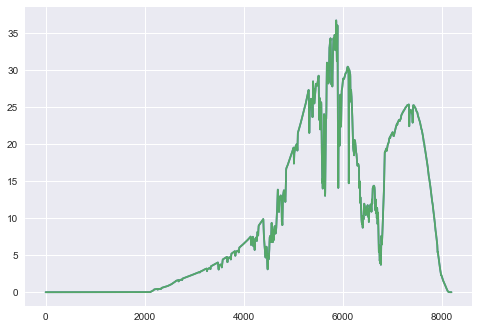

In [62]:
plt.figure()
plt.plot(m_rmf)
plt.plot(m_rmf_v)

There is, of course, also an implementation in `clarsach`:

In [65]:
from clarsach import respond

In [66]:
rmf_c = respond.RMF(datadir+"../cygx1_sims/heg_p1.rmf")

In [67]:
m_rmf_c = rmf_new.apply_rmf(m_arf)

In [68]:
np.allclose(m_rmf_c, m_rmf_v)

True

It all works! Hooray! I think we've got a solution for Chandra/HETG